# HW 6
## Dan Shao

Airbnb has become an extremely popular platform for connecting travelers with housing rentals across the world. Its users can search its extensive database of rentals, in the hopes of finding a suitable match for their travels. Let's explore **a data set of Airbnb rentals in Asheville, North Carolina**. Preview the document, the destination of Prof. Barnes's recent Spring Break getaway. The data was collected on February 17, 2019 (courtesy of Inside Airbnb) and contains the following relevant information about the rentals:

* Unique identifiers for the rental (id) and the host (host_id)
* Name for the rental (name) and host (host_name)
* Location information (neighborhood - ZIP code, latitude/longitude)
* Room type
* Average nightly price (in dollars)
* Minimum nights per stay
* Number of reviews for the rental
* Date of most recent review
* Number of reviews per month
* Number of listings by the host in the last month
* Number of available days for rental over the next year (availability_365)
* Complete the following exercises using the provided data:


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import os
import folium
%matplotlib inline
sns.set()

In [2]:
# import the data
bnb = pd.read_csv('/Users/charmain/Desktop/Master Degree/Term 2/Data Processing & Analysis in Python/Data Files/airbnb_asheville_listings.csv',index_col='id')
bnb.head(5)

,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
id,,,,,,,,,,,,,,,
38585,Charming Victorian twin BR for 2,165529,Evelyne,NaN,28804,35.65146,-82.62792,Private room,45,1,121,2018-11-25,1.20,1,60
80905,French Industrial Chic Loft,427027,AshevilleStay,NaN,28801,35.59701,-82.55237,Entire home/apt,765,1,92,2018-12-02,1.01,12,361
108061,"Walk downtown or UNCA, Pets OK!",320564,Lisa,NaN,28801,35.60670,-82.55563,Entire home/apt,75,2,85,2018-12-25,0.94,2,9
155305,Cottage! BonPaul + Sharky's Hostel,746673,BonPaul,NaN,28806,35.57972,-82.59617,Entire home/apt,107,1,195,2019-02-10,2.12,7,339
156805,"Private Room ""Ader"" at BPS Hostel",746673,BonPaul,NaN,28806,35.57755,-82.59697,Private room,71,1,51,2019-01-11,0.56,7,349


### a. (1 point) Perform an analysis of missingness in the data (i.e., what is the extent of missing values in the data and where do they occur?). Based on what you observe, perform an appropriate set of processing operations (if applicable) to manage the data appropriately. Please make sure to justify any processing steps (or lack of steps) that you perform.

In [3]:
# Have a look on missing values for all columns
bnb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2053 entries, 38585 to 32357949
Data columns (total 15 columns):
name                              2053 non-null object
host_id                           2053 non-null int64
host_name                         2053 non-null object
neighbourhood_group               0 non-null float64
neighbourhood                     2053 non-null int64
latitude                          2053 non-null float64
longitude                         2053 non-null float64
room_type                         2053 non-null object
price                             2053 non-null int64
minimum_nights                    2053 non-null int64
number_of_reviews                 2053 non-null int64
last_review                       1854 non-null object
reviews_per_month                 1854 non-null float64
calculated_host_listings_count    2053 non-null int64
availability_365                  2053 non-null int64
dtypes: float64(4), int64(7), object(4)
memory usage: 256.6+ KB


Except the three columns: neighbourhood_group, last_review and reviews_per_month, all columns has no detectable missing values. I will process these three column one by one:
* neighbourhood_group: I would like to just delete the whole column since it has no value at all.
* last_review: It is possible that the house has no review, I will check whether all of these null entries have 0 number of reviews first.
* reviews_per_month: Same as last_review, this column depends on whether there is a review. If last_review is 0 ,then of course, this number should be 0 as well.

In [4]:
# neighbourhood_group: drop the entire column
bnb.drop('neighbourhood_group',axis=1,inplace=True)

In [5]:
# last_review: check if all null entries are also 0 in number_of_reviews column
bnb.number_of_reviews[bnb.last_review.isna()].unique()

array([0])

We found that for **all entires where last_review is null, their number_of_reviews are all 0**. Since the data type of last_review is datetime, I would keep those null values. Let's check wether it is the same situation for column reviews_per_month.

In [6]:
# reviews_per_month: check if all null entries are also 0 in number_of_reviews column
bnb.number_of_reviews[bnb.reviews_per_month.isna()].unique()

array([0])

Same as last_review, if there is no reviews the reviews_per_month should be NA. I would like to replace those NA with 0.

In [7]:
bnb.reviews_per_month.fillna(0,inplace=True)

In [8]:
# check all missing values again: only last_review has several null values
bnb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2053 entries, 38585 to 32357949
Data columns (total 14 columns):
name                              2053 non-null object
host_id                           2053 non-null int64
host_name                         2053 non-null object
neighbourhood                     2053 non-null int64
latitude                          2053 non-null float64
longitude                         2053 non-null float64
room_type                         2053 non-null object
price                             2053 non-null int64
minimum_nights                    2053 non-null int64
number_of_reviews                 2053 non-null int64
last_review                       1854 non-null object
reviews_per_month                 2053 non-null float64
calculated_host_listings_count    2053 non-null int64
availability_365                  2053 non-null int64
dtypes: float64(3), int64(7), object(4)
memory usage: 240.6+ KB


Also, I noticed that there are several columns that I'd better change data type for them:
* id: int->category
* host_id: int->category
* neighbourhood: int->category
* last_review: object->datatime

In [9]:
# convert datatypes for the three columns:
bnb.host_id=bnb.host_id.astype('category')
bnb.neighbourhood=bnb.neighbourhood.astype('category')
bnb.last_review=pd.to_datetime(bnb.last_review)

In [10]:
bnb.dtypes

name                                      object
host_id                                 category
host_name                                 object
neighbourhood                           category
latitude                                 float64
longitude                                float64
room_type                                 object
price                                      int64
minimum_nights                             int64
number_of_reviews                          int64
last_review                       datetime64[ns]
reviews_per_month                        float64
calculated_host_listings_count             int64
availability_365                           int64
dtype: object

### b. (1 point) Analyze and describe the distribution of average nightly price in the data set.

In [11]:
# Have a glimpse of the price column
bnb.price.describe()

count     2053.000000
mean       160.607891
std        411.685034
min         10.000000
25%         75.000000
50%         99.000000
75%        150.000000
max      10000.000000
Name: price, dtype: float64

The max price is pretty large, 10000 dollars! And the average is significantly larger than median, so I could guess the average is affected by several extremely huge outlier numbers.

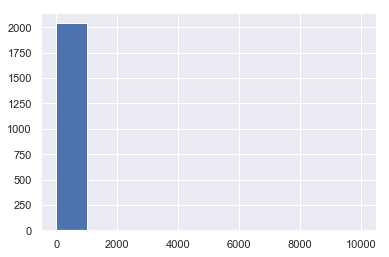

In [12]:
bnb.price.hist();

Histogram for all data tells us very few information. Let's only focus on the price under 500 dollars, which is a more general rental price range for houses in Airbnb.

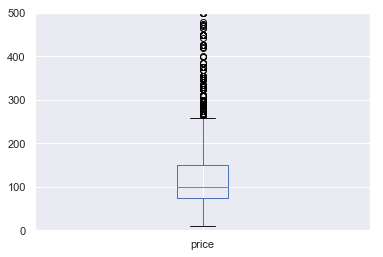

In [13]:
bnb.price.plot(kind='box')
plt.ylim(0,500);

The box-plot provides us more information for us now: most of houses charge for less than 300 dollars. Houses in the price interval from 20 to 200 are very popular. 

### c. (1 point) The room type is one of the most important characteristics of the rental, and has a significant impact on the average nightly price. Analyze the relationship between the room type and average nightly price, and describe your results.

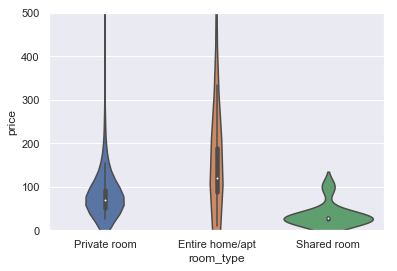

In [14]:
sns.violinplot(y=bnb.price,x=bnb.room_type)
plt.ylim(0,500);

I made the second violin-plot in order to analyze the price distribution across different room types. We could see that most of shared-room are charged below 70, but it seems like there are some high-priced share-room house, in which the customers are willing to pay more probably for better service, locations and facilities. The price for ptivate-room is nearly normally distributed if we ignore some too expensive outliers. While for entire home/apt, the standard deviation of the price distribution is very large, what I inferred is that those house might be very depending on location and customers who chose these houses are probably care less about price but other features such as design, furniture and so on.

### d. (2 points) Aside from the size of the rental, the location is probably the other critical determinant of price. Analyze the distribution of rentals by location and the relationship between the location of the rental and average nightly price, and describe your results.

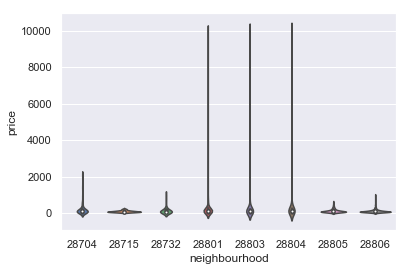

In [15]:
sns.violinplot(y=bnb.price,x=bnb.neighbourhood);

We can see that the houses in zipcode area 28801, 28803 and 28804 have a very broad price distribution, but most of the prices are below 500. We could infer that ther might be several luxury houses in those areas. Since this chart may not provide me enough information, same idea as previous question, I tried zoom-in in the next chart. 

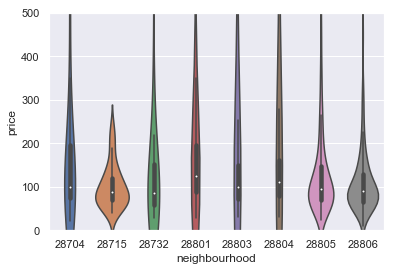

In [16]:
sns.violinplot(y=bnb.price,x=bnb.neighbourhood)
plt.ylim(0,500);

We could find more valuable information from the second chart. Houses in neighbourhood 28715, 28805 and 28806 are more like in normal distribution if we ignore some expensive outliers. But prices of houses in other areas are distributed quite dispersively, from which we could make a guess that those areas has very few but expensive houses. I cannot know whether my guess is correct or not, so I also made another jitter plot to check the distribution as well as the density of data point.

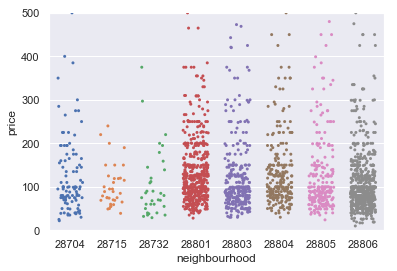

In [17]:
sns.stripplot(bnb.neighbourhood, bnb.price, jitter=0.3, size=3)
plt.ylim(0,500);

Now, I got a pretty clear overview for price distribution across different neighbourhoods. First, my inferrance is partially correct that there are very few houses in some areas such as 28704, 28715 and 28732, but not all these areas have a very dispersive distribution of price. Also, if we only look at the jitter plot we may cannot get how it distributed but if we look at violine box, it may not tell us how many observations in each category. So I combine these two charts by adding 'swarmplot' but sadly the visualization looks quite messy, which I really want to know why... (BTW, I put the chart here to prove that I did it but not for answering this question in some way since I actually cannot find clear information easily from this chart.)

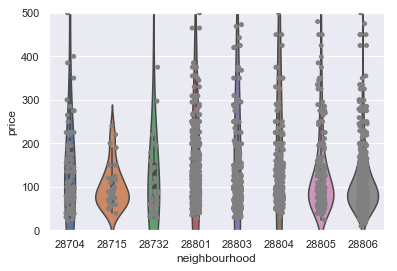

In [18]:
ax = sns.violinplot(x='neighbourhood', y='price', data=bnb)
ax = sns.stripplot(x='neighbourhood', y='price', jitter=True, data=bnb, color="grey")
plt.ylim(0,500);

### e. (2 points) Analyze and describe the distribution of the minimum number of nights for each stay. Then, segment your analysis according to room type. Does this segmentation provide any additional clarity on the requirements specified by hosts on the minimum number of nights for each stay? Please base your explanation on your results.

In [19]:
bnb.minimum_nights.describe()

count    2053.000000
mean        4.103751
std         9.151287
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max       180.000000
Name: minimum_nights, dtype: float64

Again, I chose violin chart to help me get information and it works pretty well. Also, I changed the y-axis upper range to 5 according to the information above. 

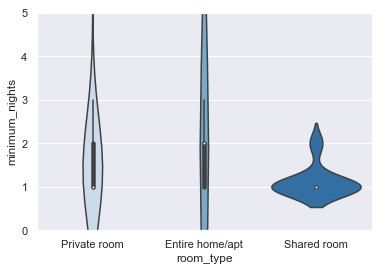

In [20]:
sns.violinplot(x=bnb["room_type"], y=bnb["minimum_nights"], palette="Blues")
plt.ylim(0,5);

I did some research for these three types of rooms in Airbnb, and the following explanations are summrized from the offical website:
* **Entire places** are best if you're seeking a home away from home. With an entire place, you'll have the whole space to yourself. 
* **Private rooms** are great for when you prefer a little privacy, and still value a local connection. When you book a private room, you'll have your own private room for sleeping and may share some spaces with others. 
* **Shared rooms** are for when you don't mind sharing a space with others. Shared rooms are popular among flexible travelers looking for new friends and budget-friendly stays.

The above explanation and the chart helped me to understand better why some host may ask customers to stay at a minimum days. Because different room types are designed for customers with different purposes of living here and the  management costs for their hosts are also totally different. For example, entire-home hosts would like customer to stay longer since it is generally not easy to find new lodger. Also, their maintainance cost per lodger is often higher than other two types of room, so it is more cost-efficiency for a entire-home host to only rent it to long-stay customers.

### f. (3 points) Perform an analysis of listing strategies, focusing on the hosts with at least 5 listings in the data set. Specifically, select 3 such hosts and analyze the listings for each of these hosts (separately). Describe in detail what you believe their strategy to be in terms of the types of properties that they acquire and make available for Airbnb travelers.

I want to choose three hosts whose number of reviews are also high, which indicates the houses are popular or we could say commercially successfu to some extent. By analyzing those hosts we may find some key simlarities among them or any strategies they considered. I sorted them out by using the following code. 

In [21]:
bnb[bnb.calculated_host_listings_count>=5].sort_values(by='number_of_reviews',ascending=False).head(50)

,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
id,,,,,,,,,,,,,,
4191204,Pineapple Paradise!,21702976,Model Communities,28801,35.60450,-82.55213,Private room,65,2,382,2019-01-20,7.20,5,326
1827412,Downtown Asheville Classic Style - Great Value...,7625694,John,28801,35.59224,-82.55120,Private room,89,1,348,2019-01-27,5.67,7,351
11905157,Breathtaking VIEWS 13 minutes to downtown HOT TUB,9216883,Shawn,28806,35.60872,-82.63354,Entire home/apt,249,1,302,2019-01-29,8.52,12,255
3888845,THE MASTER@UTOPIA ~ 50 SHADES OF 5* ~ HOT-TUB,1994122,Marc & Fay,28805,35.61288,-82.52512,Private room,59,1,290,2019-02-15,5.37,9,164
16415290,"Hot Tub On Haywood Road, Walk/Bike Everywhere",9216883,Shawn,28806,35.57928,-82.57720,Entire home/apt,128,1,287,2019-02-02,10.88,12,344
5144212,"Close to breweries, eclectic shops & restaurants",6074062,Melissa,28801,35.59661,-82.55295,Entire home/apt,225,1,284,2019-01-27,5.91,5,308
4183263,Stardust Sprinkles in the Hoon's Moon Room,21702976,Model Communities,28801,35.60363,-82.55172,Private room,65,2,276,2019-01-20,5.22,5,283
14737689,"Asheville mountain views, king beds + HOT TUB",9216883,Shawn,28806,35.63326,-82.65826,Entire home/apt,279,1,265,2019-02-05,8.78,12,322
6818139,Downtown Asheville Antique Style- Great Value!...,7625694,John,28801,35.59132,-82.55101,Private room,89,2,264,2019-01-20,5.91,7,343


According to the result and also considering the balance of types of houses, I choose these three hosts:
* **BonPaul**: 7 houses on the list and 4 of them are in top 50 number-of-review ranking and also the only host whose Shared room entered in the ranking. BonPaul has mixed types of houses: 4 Shared room houses, 2 Private room houses and 1 Entire room.
* **Shawn**: 9 out of 12 houses are in the top 50 ranking, all houese are Entire room.
* **Marc & Fay**: all 9 houses are in the ranking, and 6 of them are Private room, another 3 are Entire room.

Now, let's have a look for the three hosts I chosen.

In [22]:
# BonPaul:
bonpaul = bnb[bnb.host_name=='BonPaul'].sort_values(by='number_of_reviews',ascending=False)
bonpaul

,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
id,,,,,,,,,,,,,,
156926,"Mixed Dorm ""Top Bunk #1"" at BPS Hostel",746673,BonPaul,28806,35.57776,-82.59500,Shared room,26,1,213,2019-02-05,2.34,7,351
155305,Cottage! BonPaul + Sharky's Hostel,746673,BonPaul,28806,35.57972,-82.59617,Entire home/apt,107,1,195,2019-02-10,2.12,7,339
6765734,"Female Dorm ""Top Bunk #2"" at Sharky's Hostel",746673,BonPaul,28806,35.57812,-82.59480,Shared room,27,1,80,2019-01-05,1.83,7,344
12286328,Mixed Dorm Lower Bunk #1,746673,BonPaul,28806,35.57916,-82.59639,Shared room,27,1,65,2019-02-05,1.87,7,349
156805,"Private Room ""Ader"" at BPS Hostel",746673,BonPaul,28806,35.57755,-82.59697,Private room,71,1,51,2019-01-11,0.56,7,349
12989718,Female Dorm Single Bed at BPS Hostel,746673,BonPaul,28806,35.57806,-82.59661,Shared room,27,1,48,2019-02-05,1.43,7,344
6765832,"Private Room ""Hitchcock"" BPS Hostel",746673,BonPaul,28806,35.57775,-82.59627,Private room,72,1,21,2019-01-27,0.47,7,350


In [23]:
# Shawn:
shawn = bnb[bnb.host_name=='Shawn'].sort_values(by='number_of_reviews',ascending=False)
shawn

,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
id,,,,,,,,,,,,,,
11905157,Breathtaking VIEWS 13 minutes to downtown HOT TUB,9216883,Shawn,28806,35.60872,-82.63354,Entire home/apt,249,1,302,2019-01-29,8.52,12,255
16415290,"Hot Tub On Haywood Road, Walk/Bike Everywhere",9216883,Shawn,28806,35.57928,-82.57720,Entire home/apt,128,1,287,2019-02-02,10.88,12,344
14737689,"Asheville mountain views, king beds + HOT TUB",9216883,Shawn,28806,35.63326,-82.65826,Entire home/apt,279,1,265,2019-02-05,8.78,12,322
18715985,"Modern Lodge on the river, West Asheville",9216883,Shawn,28806,35.56716,-82.57012,Entire home/apt,299,1,172,2019-02-01,8.36,12,339
17750453,CLOSE TO DOWNTOWN ASHEVILLE - HOT TUB KING BEDS,9216883,Shawn,28806,35.59418,-82.59217,Entire home/apt,149,1,165,2019-02-06,7.18,12,344
19629824,Historic Haywood Haven HOT TUB KING BEDS walkable,9216883,Shawn,28806,35.57842,-82.57768,Entire home/apt,259,1,153,2019-01-29,8.04,12,348
18004232,"Spacious, close to downtown, HOT TUB, king beds",9216883,Shawn,28805,35.60249,-82.46945,Entire home/apt,249,1,148,2019-02-16,6.71,12,341
24333659,Sand Hill Villa - King bed + hot tub! Creek!,9216883,Shawn,28806,35.56035,-82.61127,Entire home/apt,119,30,69,2019-02-13,7.24,12,34
25378033,Glamping in the City! Hot tub! King beds!,9216883,Shawn,28806,35.59425,-82.59293,Entire home/apt,99,1,60,2018-11-26,7.29,12,0


In [24]:
# Marc & Fay:
m_f = bnb[bnb.host_name=='Marc & Fay'].sort_values(by='number_of_reviews',ascending=False)
m_f

,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
id,,,,,,,,,,,,,,
3888845,THE MASTER@UTOPIA ~ 50 SHADES OF 5* ~ HOT-TUB,1994122,Marc & Fay,28805,35.61288,-82.52512,Private room,59,1,290,2019-02-15,5.37,9,164
2213748,5* SUNSET SUITE IN LUX VILLA ~ HOT-TUB ~ 2M DTN,1994122,Marc & Fay,28805,35.60722,-82.53155,Private room,49,1,236,2019-02-12,3.94,9,175
13648659,5* STEEL SUITE@UTOPIA ~ HOT-TUB ~ <$10 UBER DTN,1994122,Marc & Fay,28805,35.61258,-82.52601,Entire home/apt,69,1,205,2019-02-11,6.64,9,171
13258472,5* STEAMPUNK SUITE@UTOPIA ~ HOT-TUB ~ UBER <$10,1994122,Marc & Fay,28805,35.61140,-82.52366,Entire home/apt,59,1,203,2019-02-13,6.35,9,172
2751374,5* APARTMENT ~ PRIVATE HOT-TUB ~ MOUNTAIN VIEWS,1994122,Marc & Fay,28805,35.61194,-82.52522,Entire home/apt,66,30,175,2018-07-08,3.00,9,45
5532718,5* SUNRISE SUITE IN LUX VILLA ~ HOT-TUB ~ MTN ...,1994122,Marc & Fay,28805,35.60802,-82.52963,Private room,49,1,160,2019-02-10,3.41,9,172
14731928,5* BRICKHOUSE SUITE@UTOPIA ~ HOT-TUB ~ LYFT <$10,1994122,Marc & Fay,28805,35.61290,-82.52441,Private room,49,1,140,2019-01-29,4.76,9,168
21190372,5* SPA SUITE@HIDEAWAY ~ KING BED ~ PRIVATE SPA,1994122,Marc & Fay,28805,35.60564,-82.53507,Private room,49,1,91,2019-02-11,5.49,9,162
21231387,TREEHOUSE SUITE ~ KING BED ~ PRIVATE HOT-TUB,1994122,Marc & Fay,28804,35.60592,-82.53700,Private room,49,1,55,2019-02-14,3.31,9,171


#### BonPaul

Price for different types of houese: Having a glimpse on the price-room_type pivot table, we could easily find that the pricing BonPaul is significantly lower than overall average price for each type of houses. Except price of Private room is slightly higher than regional average price, prices of other two types are competitive comparing to other houses in the same neighbourhood. This pricing strategy is called **Market-penetration Pricing Strategy**, a pricing strategy setting a low price in order to attract a large number of customers. We could also say that BonPaul creates a very successful pricing mix, by which all houses are very attractive for different levels of targeting customers. 

In [25]:
bon = bonpaul.pivot_table(index='room_type',values='price',aggfunc='mean')
bon.columns=['BonPaul avg.price']
All = bnb.pivot_table(index='room_type',values='price',aggfunc='mean')
All.columns=['Overall avg.price']
nei = bnb[bnb.neighbourhood==28806].pivot_table(index='room_type',values='price',aggfunc='mean')
nei.columns=['Neighbourhood avg.price']
bon_all_nei = pd.concat([bon, All, nei], axis=1)
bon_all_nei

,BonPaul avg.price,Overall avg.price,Neighbourhood avg.price
room_type,,,
Entire home/apt,107.00,188.132432,131.314685
Private room,71.50,90.281416,66.544379
Shared room,26.75,35.375000,41.400000


Besides price, I also found that BonPaul tries its best to make customer more convenient. The available days of Entire room and Private are significantly higher than average level of the same neighbourhood. Moreover, customers could even stay only one night in BonPaul's Entire or Private rooms. These two aspects also make BonPaul outperform its competitors.

In [26]:
bon = bonpaul.pivot_table(index='room_type',values=['number_of_reviews',
                                                    'minimum_nights','availability_365'],aggfunc='mean')
bon.columns=['BonPaul availability', 'BonPaul min nights','BonPual # of reviews']
nei = bnb[bnb.neighbourhood==28806].pivot_table(index='room_type',values=['number_of_reviews',
                                                    'minimum_nights','availability_365'],aggfunc='mean')
nei.columns=['Neighbourhood availability', 'Neighbourhood min nights','Neighbourhood # of reviews']
bon_nei = pd.concat([bon, nei], axis=1)
bon_nei = bon_nei[['BonPaul availability','Neighbourhood availability',
                   'BonPaul min nights','Neighbourhood min nights',
                   'BonPual # of reviews','Neighbourhood # of reviews']]
bon_nei

,BonPaul availability,Neighbourhood availability,BonPaul min nights,Neighbourhood min nights,BonPual # of reviews,Neighbourhood # of reviews
room_type,,,,,,
Entire home/apt,339.0,188.524476,1,3.979021,195.0,67.729604
Private room,349.5,142.763314,1,1.911243,36.0,58.804734
Shared room,347.0,350.600000,1,1.200000,101.5,81.200000


#### Shawn

Shawn only provides Entire room, which price is usually expensive than other two types of room and residents also tend to have higher requirements for the house. We could hardly know whether the house offerings are good or not from the given data so let's focus on price first.

In [27]:
mean_entire_room = bnb[bnb.room_type=='Entire home/apt'].price.mean()
mean_entire_room

188.13243243243244

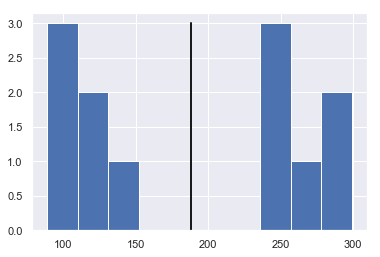

In [28]:
shawn['price'].hist()
plt.plot([mean_entire_room, mean_entire_room], [0,3], 'k-', lw=2);

We see that half of the houses in Shawn have prices lower than average price (the black line: x = 188), and it is hard to infer why Shawn is popular among customers by now. Let's put price and number of reviews together in a chart to see how latter is distributed across price.

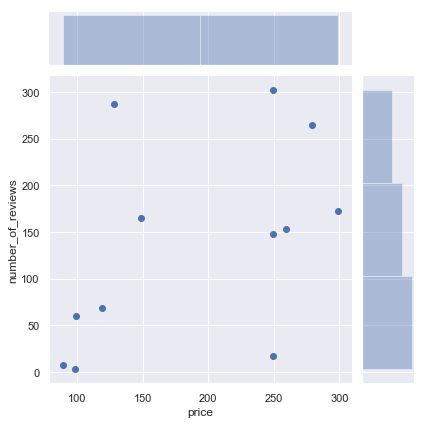

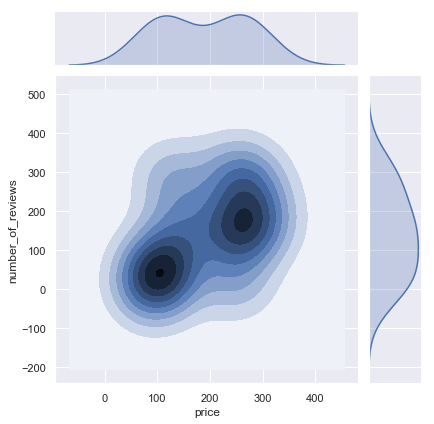

In [29]:
sns.jointplot(x=shawn["price"], y=shawn["number_of_reviews"], kind='scatter');
sns.jointplot(x=shawn["price"], y=shawn["number_of_reviews"], kind='kde');

I find that high-price houses in Shawn are more popular, which is a result out of my expectation. In common sense, lower price products or services are more popular among customers but in Shawn's situation, the thing is conversely happened. Since the data do not provide me enough information to help me dig out the reason, I just make a simple guess that maybe, Shawn's expensive houses satisfied lodgers successfully or those houses have a good positioning image to always attract the target customers successfully.

#### Marc & Fay

Same as previous analyses, I would like to compare price first, since price is always a very determinant factor.

In [30]:
MF = m_f.pivot_table(index='room_type',values='price',aggfunc='mean')
MF.columns=['Marc & Fay avg.price']
nei = bnb[bnb.neighbourhood==28805].pivot_table(index='room_type',values='price',aggfunc='mean')
nei.columns=['Neighbourhood avg.price']
MF_nei = pd.concat([MF, nei], axis=1)
MF_nei

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


,Marc & Fay avg.price,Neighbourhood avg.price
Entire home/apt,64.666667,152.970060
Private room,50.666667,73.909091
Shared room,NaN,24.000000


I find that the house prices in Marc & Fay are lower than regional price, especially Entire room price (more than half cheaper than average price, which is very very competitive). I also want to know why Marc & Fay set price in a such low level, is there any inconvenience that customers have to tolerant behind the low price? 

In [31]:
MF = m_f.pivot_table(index='room_type',values=['minimum_nights','availability_365'],aggfunc='mean')
MF.columns=['Marc & Fay availability', 'Marc & Fay min nights']

nei = bnb[bnb.neighbourhood==28805].pivot_table(index='room_type',values=['minimum_nights',
                                                                          'availability_365'],aggfunc='mean')
nei.columns=['Neighbourhood availability', 'Neighbourhood min nights']

MF_nei = pd.concat([MF, nei], axis=1)
MF_nei = MF_nei[['Marc & Fay availability','Neighbourhood availability',
                 'Marc & Fay min nights','Neighbourhood min nights']]
MF_nei

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,Marc & Fay availability,Neighbourhood availability,Marc & Fay min nights,Neighbourhood min nights
Entire home/apt,129.333333,223.011976,10.666667,3.526946
Private room,168.666667,156.696970,1.000000,1.833333
Shared room,NaN,0.000000,NaN,1.000000


My guess is correct that the requirements of Entire room for customers are quite inconvenient relatively. First the average availability days is only 129 days annually, about half of year the house would not be avaliable. Also, lodgers have to stay, on average, more than 10 days, customers who are in short-traveling will definitely consider other houses. With such high requirements, the houses are still welcomed by customers, it is might be the houses in Marc & Fay outperform in other aspects such as room size, the facilities inside, and of course, the price.